In [1]:
import pickle
filename = "ds.pkl"
ds = pickle.load(open(filename, 'rb'))

In [2]:
import pickle
filename = "px.pkl"
px = pickle.load(open(filename, 'rb'))

In [3]:
identifiers = ['user_id', 'request_id', 'target_recipient_id']
date_cols = ['date_user_created', 'date_request_submitted', 'date_request_received','date_request_transferred', \
             'first_attempt_date', 'first_success_date']
categorical = ['addr_country_code', 'addr_city', 'recipient_country_code', 'flag_personal_business', 'payment_type', \
               'payment_status', 'ccy_send', 'ccy_target', 'transfer_to_self', 'sending_bank_name',  'sending_bank_country',\
               'payment_reference_classification', 'device']

# Sort the Customers by there Anomalous Behavior

In [4]:
custs = ds.sort_values(['anomalous_score'])[['user_id', 'addr_country_code', 'addr_city', 'anomalous']].head(10)
custs

,user_id,addr_country_code,addr_city,anomalous
57362,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
48695,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
5779,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
35815,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
47108,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
14917,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
15194,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
10023,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
34178,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1
44262,69fd02c4fbd5bfa6533f7a5eac3bd81c,FIN,HELSINKI,1


In [5]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

class knn(NearestNeighbors):
    def predict(self, x):
        return self.kneighbors(x, 100)

class dateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Processing DateTime Data')
        print('Encoding....')
        retX = pd.DataFrame()
        #print(X)
        for colname, col in X.iteritems():
            retX[colname+'_dayofweek'] = col.dt.dayofweek
            retX[colname+'_weekday'] = col.dt.weekday
            retX[colname+'_hour'] = col.dt.hour
            retX[colname+'_minute'] = col.dt.minute
            retX[colname+'_day'] = col.dt.day
            retX[colname+'_month'] = col.dt.month
            #retX[colname+'_year'] = col.dt.year
    
        return retX
    
def prepare_pipeline(ds):
    
    numeric_features = ds.select_dtypes(include=[np.float or np.float]).columns.tolist()
    categorical_features = ds.select_dtypes(include=['object']).columns.tolist()
    date_features = ds.select_dtypes(include=[np.datetime64]).columns.tolist()
    
    cachedir = mkdtemp()
    memory = Memory(cachedir=cachedir, verbose=1)

    date_transformer = Pipeline(memory=memory, steps=[('dateEncoder', dateEncoder()), ('imputer', SimpleImputer(strategy='median', verbose=1))])
    numeric_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='median', verbose=1))])
    categorical_transformer = Pipeline(memory=memory, steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing', verbose=1)),
                                                             ('onehot', OneHotEncoder(handle_unknown='ignore'))])    

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('dates', date_transformer, date_features),
                                                   ('cat', categorical_transformer, categorical_features)])

    clustering = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('svd', TruncatedSVD(n_components=20, n_iter=10, random_state=42)),
                                 ('std', StandardScaler()),
                                 ('clustering', knn())])
    
    return clustering

In [6]:
clustering = prepare_pipeline(ds[[c for c in ds.columns.tolist() if c not in identifiers]])

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmp2pqyzbax'", use "location='C:\\Users\\KHALID~1\\AppData\\Local\\Temp\\tmp2pqyzbax'" instead.


In [7]:
clustering = clustering.fit(ds[[c for c in ds.columns.tolist() if c not in identifiers]])

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(dateEncoder(),         date_user_created date_request_submitted date_request_received  \
0     2014-01-27 15:02:00    2016-08-26 07:35:00   2016-01-09 08:31:00   
1     2015-12-10 15:35:00    2016-10-23 22:54:00                   NaT   
2     2016-04-10 11:42:00    2016-10-26 13:42:00   2016-10-26 14:06:00   
3     2014-10-17 00:27:00    2015-01-28 23:36:00   2015-01-28 23:36:00   
4     2015-12-08 07:45:00    2015-08-18 08:55:00   2015-08-18 09:12:00   
5     2016-04-19 16:30:00    2016-02-10 11:59:00   2016-02-10 12:00:00   
6     2015-10-15 19:48:00    2016-12-08 20:54:00   2016-12-08 20:54:00   
7     2015-12-03 21:04:00    2015-05-31 09:49:00   2015-05-31 09:52:00   
8     2015-04-30 16:05:00    2015-..., 
None, None)
Processing DateTime Data
Encoding....
________________________________________________fit_transform_one - 0.2s,

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min


# As an example of similarty, take the top anomalous transfer

In [25]:
ix = 0

In [26]:
instant = pd.DataFrame(dict(zip(ds.iloc[custs.index[ix]][[c for c in ds.columns.tolist() if c not in identifiers]].index.values, ds.iloc[custs.index[ix]][[c for c in ds.columns.tolist() if c not in identifiers]].values)), index=[0])

In [27]:
instant

,date_user_created,addr_country_code,addr_city,recipient_country_code,flag_personal_business,payment_type,date_request_submitted,date_request_received,date_request_transferred,date_request_cancelled,...,sending_bank_name,sending_bank_country,payment_reference_classification,device,transfer_sequence,days_since_previous_req,first_attempt_date,first_success_date,anomalous_score,anomalous
0,2014-11-26 11:04:00,FIN,HELSINKI,NL,Business,Bank Transfer,2016-10-31 13:35:00,2016-01-11 07:03:00,2016-01-11 15:16:00,NaN,...,POHJOLA PANKKI OYJ (POHJOLA BANK PLC),FI,invoice,Desktop Web,8712.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.014018,1


In [28]:
similars = clustering.predict(instant)

Processing DateTime Data
Encoding....


## Top 5 similar transfers to that instant 

### only the first one is anomalous

## the top five similar transfers are comming from the same user_id

In [29]:
ds.iloc[similars[1][0]].head(5)

,user_id,request_id,target_recipient_id,date_user_created,addr_country_code,addr_city,recipient_country_code,flag_personal_business,payment_type,date_request_submitted,...,sending_bank_name,sending_bank_country,payment_reference_classification,device,transfer_sequence,days_since_previous_req,first_attempt_date,first_success_date,anomalous_score,anomalous
57362,69fd02c4fbd5bfa6533f7a5eac3bd81c,8a0e22659ce2072497165a4ddefbe631,946bd1f5e726291c99dadd06a5189718,2014-11-26 11:04:00,FIN,HELSINKI,NL,Business,Bank Transfer,2016-10-31 13:35:00,...,POHJOLA PANKKI OYJ (POHJOLA BANK PLC),FI,invoice,Desktop Web,8712.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.014018,1
96952,69fd02c4fbd5bfa6533f7a5eac3bd81c,0ed6d004fbbdef3368ef24bddc199c02,86cafaba5ec5232913bc70eb24be2494,2014-11-26 11:04:00,FIN,HELSINKI,SE,Business,Bank Transfer,2016-11-29 10:18:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,9230.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.007760,1
29164,69fd02c4fbd5bfa6533f7a5eac3bd81c,924c04a44f88568f9e43522b9c5dd299,d915efb5e361801178694fee0ecdf621,2014-11-26 11:04:00,FIN,HELSINKI,SE,Business,Bank Transfer,2016-10-31 13:14:00,...,POHJOLA PANKKI OYJ (POHJOLA BANK PLC),FI,Other/unknown,Desktop Web,8676.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.012309,1
39007,69fd02c4fbd5bfa6533f7a5eac3bd81c,2a04354be989d9562b0c2c7e24208332,ca5c23f854fd03bd8cdb26522da7bd22,2014-11-26 11:04:00,FIN,HELSINKI,SE,Business,NaN,2016-10-25 11:39:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,8468.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.007517,1
10440,69fd02c4fbd5bfa6533f7a5eac3bd81c,36d468dc36c6490edfcb16db5109639c,35d783e4ffc5042ce4d49e924e6a8448,2014-11-26 11:04:00,FIN,HELSINKI,SE,Business,NaN,2016-10-24 12:50:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,8418.0,0.0,2014-02-12 11:05:00,2014-05-12 08:01:00,-0.007837,1


## the top five similar transfers are comming from the different user_id

In [44]:
ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].head(5)

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,request_id,target_recipient_id,date_user_created,addr_country_code,addr_city,recipient_country_code,flag_personal_business,payment_type,date_request_submitted,...,sending_bank_name,sending_bank_country,payment_reference_classification,device,transfer_sequence,days_since_previous_req,first_attempt_date,first_success_date,anomalous_score,anomalous
94646,b78c8ce3f52611c3df21da6b9effe911,13336575f77b6bcf8150d4706dfe5f70,616592c92d5822778f6dbd24e8a8a9ce,2016-11-21 09:14:00,EST,TALLINN,GB,Personal,NaN,2016-11-21 12:20:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,8976.0,0.0,2016-11-21 11:31:00,NaT,0.00219,0
93843,b78c8ce3f52611c3df21da6b9effe911,7a1844430c4dbe11e5e45a736f84e1bd,d1da4339464786aae1e6a5f9a41541be,2016-11-21 09:14:00,EST,TALLINN,GB,Personal,NaN,2016-11-21 12:20:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,9015.0,0.0,2016-11-21 11:31:00,NaT,0.00219,0
95568,b78c8ce3f52611c3df21da6b9effe911,e04933e9c3f9810a5f57ad4996db4033,52afe70eb729ee853cbc47061ff70dd2,2016-11-21 09:14:00,EST,TALLINN,GB,Personal,NaN,2016-11-21 12:21:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,9305.0,0.0,2016-11-21 11:31:00,NaT,0.00219,0
22197,b78c8ce3f52611c3df21da6b9effe911,c203eac78b04e58eeb062e51c2612c73,65a97954685381c7ae12f4c2de002a7e,2016-11-21 09:14:00,EST,TALLINN,GB,Personal,NaN,2016-11-21 12:20:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,9181.0,0.0,2016-11-21 11:31:00,NaT,0.00219,0
81866,b78c8ce3f52611c3df21da6b9effe911,67f4f4c889a4e28b2244a7f2ce3bf7e1,1af8e6781d9e37b2f330dddeba4dedf0,2016-11-21 09:14:00,EST,TALLINN,GB,Personal,NaN,2016-11-21 12:19:00,...,Other/unknown,Other/unknown,Other/unknown,Desktop Web,8817.0,0.0,2016-11-21 11:31:00,NaT,0.00219,0


In [31]:
import matplotlib.pyplot as plt
import random

In [32]:
y = ds['anomalous'].values

In [ ]:
ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].head(5)

In [49]:
px[ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].head(5).index.values].shape[0]

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


5

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


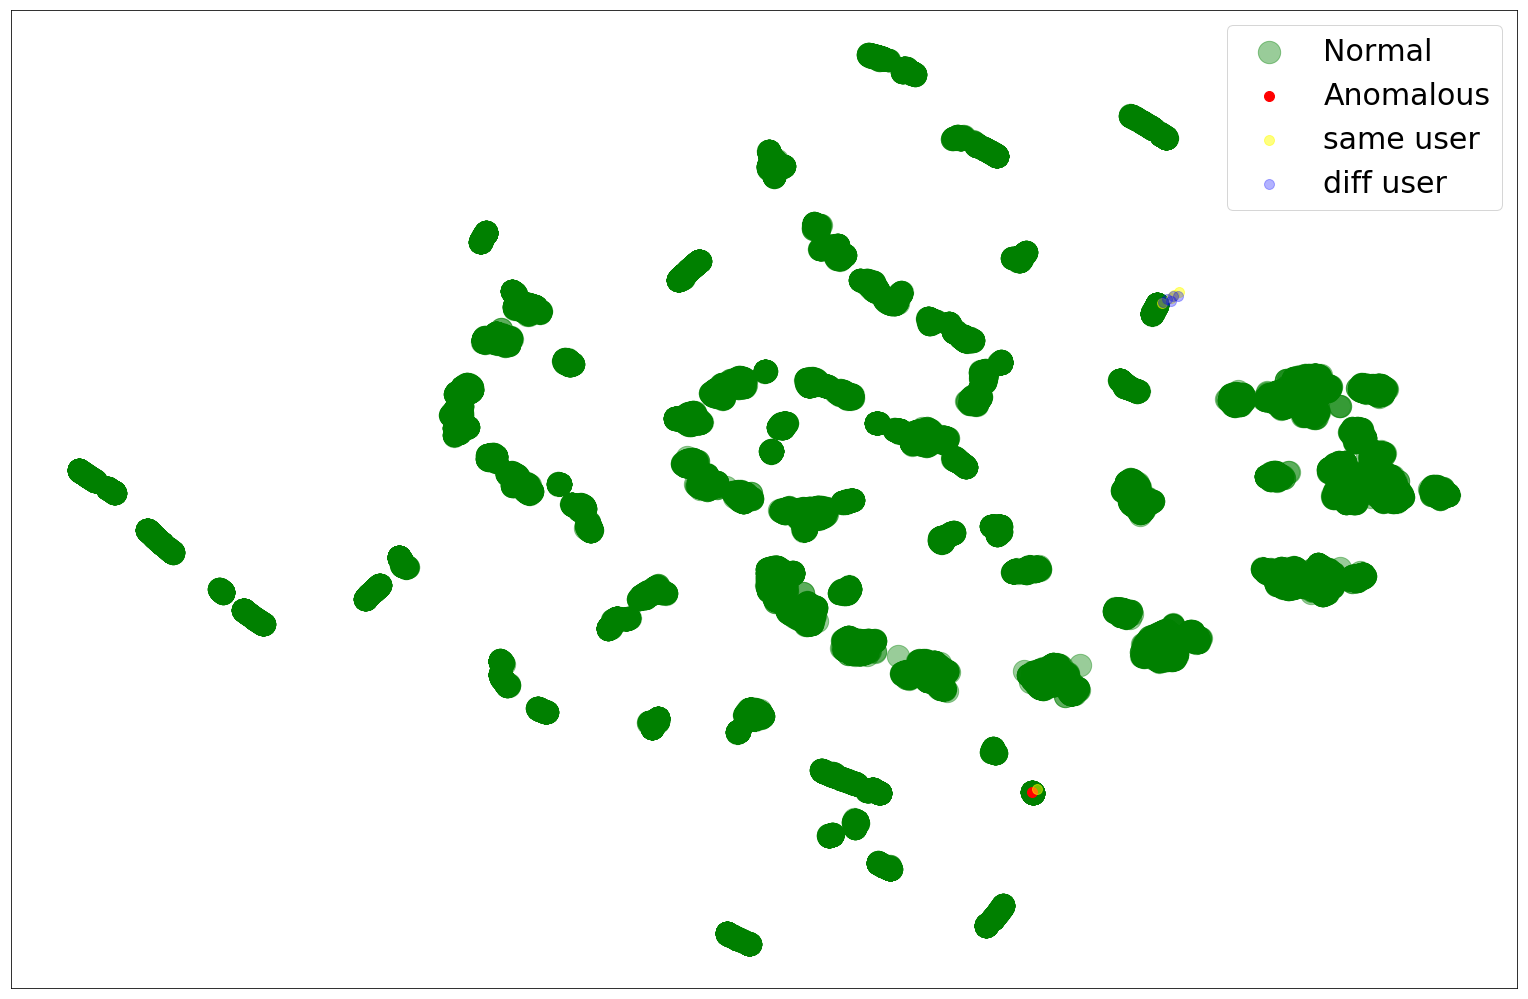

In [59]:
plt.figure(figsize=(27,18))
plt.scatter(px[:, 0][y==0], px[:, 1][y==0], s=500, c='green', alpha=0.4, label='Normal')

plt.scatter(px[:, 0][custs.index[ix]], \
            px[:, 1][custs.index[ix]], s=100, c='red', label='Anomalous')

for i in range(px[ds.iloc[similars[1][0]].head(5).index.values].shape[0]):
    if i==0: 
        plt.scatter(px[:, 0][ds.iloc[similars[1][0]].index.values][i] + (i+1)*random.random()+1, \
                    px[:, 1][ds.iloc[similars[1][0]].index.values][i] + (i+1)*random.random()+1, \
                    marker='o', alpha=0.5, s=100, c='yellow', label='same user')
    else:
        plt.scatter(px[:, 0][ds.iloc[similars[1][0]].index.values][i] + (i+1)*random.random()+1, \
                    px[:, 1][ds.iloc[similars[1][0]].index.values][i] + (i+1)*random.random()+1, \
                    marker='o', alpha=0.5, s=100, c='yellow')

for i in range(px[ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].head(5).index.values].shape[0]):
    if i==0:
        plt.scatter(px[:, 0][ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].index.values][i] + (i+1)*random.random()+1, \
                    px[:, 1][ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].index.values][i] + (i+1)*random.random()+1, \
                    marker='o', alpha=0.3, s=100, c='blue', label='diff user')
    else:
        plt.scatter(px[:, 0][ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].index.values][i] + (i+1)*random.random()+1, \
            px[:, 1][ds.iloc[similars[1][0]][ds.user_id!='69fd02c4fbd5bfa6533f7a5eac3bd81c'].index.values][i] + (i+1)*random.random()+1, \
            marker='o', alpha=0.3, s=100, c='blue')

plt.xticks([]), plt.yticks([])
plt.legend(prop={'size': 30})

In [60]:
import pickle
filename = "clustering.pkl"
pickle.dump(clustering, open(filename, 'wb'))